In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR
from sklearn import metrics
from mlxtend.plotting import plot_learning_curves
from sklearn.model_selection import GridSearchCV

In [3]:
file = 'all_seasons.csv'
data = pd.read_csv(file, index_col= 0)

# revise draft data
data['drafted'] = np.where(data['draft_year'] != 'Undrafted', 1, 0 )
data['draft_year'] = data['draft_year'].replace(r'Undrafted', np.nan, regex = True)

#Convert year data to datetime
data['draft_year'] = pd.to_datetime(data['draft_year'])
data['season'] = pd.to_datetime(data['season'].str[:4])

data['draft_year'] = data['draft_year'].dt.year
data['season'] = data['season'].dt.year

# add positions
data['position'] = 'NA'
data['position'][data['player_height'] >= 206] = 'Center'
data['position'][data['player_height'] <= 195] = 'Guard'
data['position'][(data.player_height > 195)&(data.player_height < 206 )] = 'Forward'
data.head()

<ipython-input-3-d0f91c23295f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['position'][data['player_height'] >= 206] = 'Center'
<ipython-input-3-d0f91c23295f>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['position'][data['player_height'] <= 195] = 'Guard'
<ipython-input-3-d0f91c23295f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['position'][(data.player_height > 195)&(data.player_height < 206 )] = 'Forwa

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,drafted,position
0,Dennis Rodman,CHI,36.0,198.12,99.790240,Southeastern Oklahoma State,USA,1986.0,2,27,...,3.1,16.1,0.186,0.323,0.100,0.479,0.113,1996,1,Forward
1,Dwayne Schintzius,LAC,28.0,215.90,117.933920,Florida,USA,1990.0,1,24,...,0.3,12.3,0.078,0.151,0.175,0.430,0.048,1996,1,Center
2,Earl Cureton,TOR,39.0,205.74,95.254320,Detroit Mercy,USA,1979.0,3,58,...,0.4,-2.1,0.105,0.102,0.103,0.376,0.148,1996,1,Forward
3,Ed O'Bannon,DAL,24.0,203.20,100.697424,UCLA,USA,1995.0,1,9,...,0.6,-8.7,0.060,0.149,0.167,0.399,0.077,1996,1,Forward
4,Ed Pinckney,MIA,34.0,205.74,108.862080,Villanova,USA,1985.0,1,10,...,0.2,-11.2,0.109,0.179,0.127,0.611,0.040,1996,1,Forward


# Case Study: Lebron James

Lebron James has been known as one of the best players of all time. Part of this stems from the fact that he is near indesctructible, having been playing in the NBA since 2003 (16 seasons)! Lets look at how he does this.

How has his performance changed over time? Is time wearing down on him?

In [4]:
lebron_data = data[data['player_name'] == 'LeBron James']
lebron_data.head()

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,drafted,position
3120,LeBron James,CLE,19.0,203.2,108.86208,None,USA,2003.0,1,1,...,5.9,-2.6,0.035,0.117,0.280,0.488,0.268,2003,1,Forward
3617,LeBron James,CLE,20.0,203.2,108.86208,None,USA,2003.0,1,1,...,7.2,1.9,0.038,0.170,0.297,0.554,0.324,2004,1,Forward
4075,LeBron James,CLE,21.0,203.2,108.86208,None,USA,2003.0,1,1,...,6.6,4.2,0.026,0.171,0.336,0.568,0.315,2005,1,Forward
4778,LeBron James,CLE,22.0,203.2,108.86208,None,USA,2003.0,1,1,...,6.0,5.4,0.029,0.166,0.309,0.552,0.281,2006,1,Forward
5104,LeBron James,CLE,23.0,203.2,113.39800,None,USA,2003.0,1,1,...,7.2,2.4,0.049,0.178,0.333,0.568,0.352,2007,1,Forward


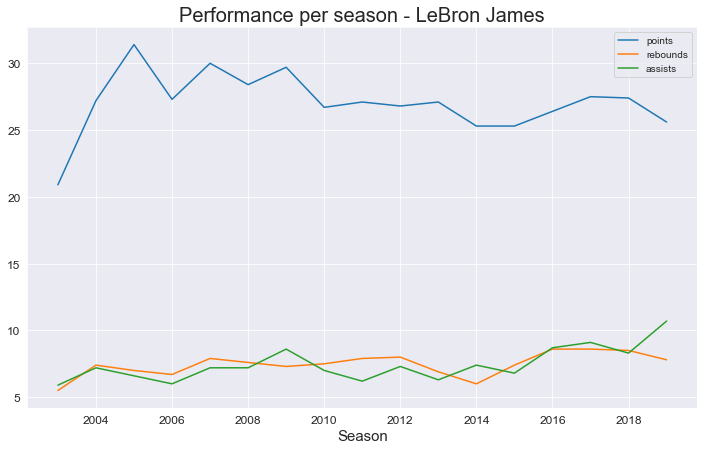

Career points per season: 27.064705882352943
Career rebounds per season: 7.447058823529411
Career assists per season: 7.441176470588236


In [14]:
# Explore his performance

plt.figure(figsize = (12,7))
sns.set_style('darkgrid')
plt.plot(lebron_data['season'], lebron_data['pts'], label = 'points')
plt.plot(lebron_data['season'], lebron_data['reb'], label = 'rebounds')
plt.plot(lebron_data['season'], lebron_data['ast'], label = 'assists')
plt.title('Performance per season - LeBron James', fontsize = 20)
plt.legend(loc = 'best')
plt.xlabel('Season', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

print(f"Career points per season: {np.mean(lebron_data['pts'])}")
print(f"Career rebounds per season: {np.mean(lebron_data['reb'])}")
print(f"Career assists per season: {np.mean(lebron_data['ast'])}")

In [47]:
vince = data[data['player_name'] == 'Vince Carter']
comparison = vince[['pts', 'season']]
comparison.rename(columns = {'pts': 'vince_pts', 'season': 'vince_season'}, inplace = True)
lebron = data[data['player_name'] == 'LeBron James']
lebron = lebron[['pts', 'season']]
lebron.rename(columns = {'pts': 'LeBron_pts', 'season': 'lebron_season'}, inplace = True)
comparison.reset_index(inplace = True)
lebron.reset_index(inplace = True)
comparison['lebron_pts'] = lebron['LeBron_pts']
comparison['lebron_season'] = lebron['lebron_season']
comparison.drop([17,18,19,20,21], inplace = True)
years = np.arange(1,18)
comparison['years_in_league'] = years
print(comparison)

    index  vince_pts  vince_season  lebron_pts  lebron_season  years_in_league
0    1005       18.3          1998        20.9         2003.0                1
1    1604       25.7          1999        27.2         2004.0                2
2    2125       27.6          2000        31.4         2005.0                3
3    2353       24.7          2001        27.3         2006.0                4
4    2911       20.6          2002        30.0         2007.0                5
5    3222       22.5          2003        28.4         2008.0                6
6    3672       24.5          2004        29.7         2009.0                7
7    4132       24.2          2005        26.7         2010.0                8
8    4430       25.2          2006        27.1         2011.0                9
9    5262       21.3          2007        26.8         2012.0               10
10   5695       20.8          2008        27.1         2013.0               11
11   6074       16.6          2009        25.3      

We can see that as soon as Lebron entered the league, he was a star. As a rookie, he was averaging more than 20 points per game. Thats incredible! This continued for a number of years as he developed.

The data also shows that he was able to be an all-round player, with high assists and rebounds.

Further, we can see that he has been able to maintain an incredible points per game average (as well as ast/reb throughout all of his 16 seasons in the league.

To put this into perspective, lets look at a similar case where someone was in the league for an extended period of time: Vince Carter, who was in the league for 22 seasons (drafter in 1998 season - ended career 2020 season)

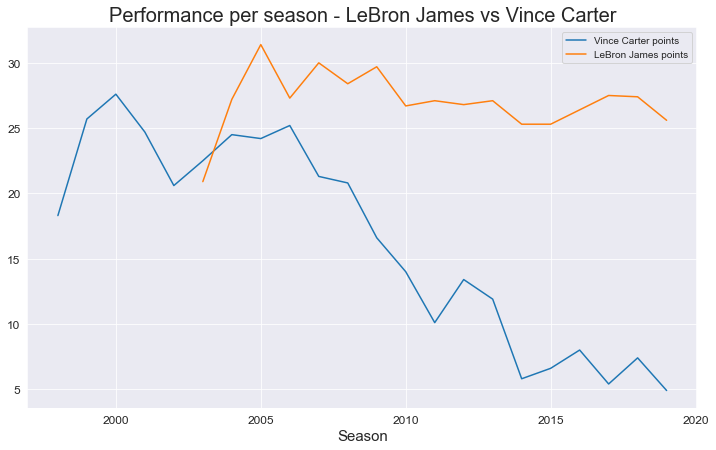

In [15]:
# obtain vince carters data
vince_data = data[data['player_name'] == 'Vince Carter']

# compare their performance (points)
plt.figure(figsize = (12,7))
plt.plot(vince_data['season'], vince_data['pts'], label = 'Vince Carter points')
plt.plot(lebron_data['season'], lebron_data['pts'], label = 'LeBron James points')
plt.legend(loc = 'best')
plt.title('Performance per season - LeBron James vs Vince Carter', fontsize = 20)
plt.xlabel('Season', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

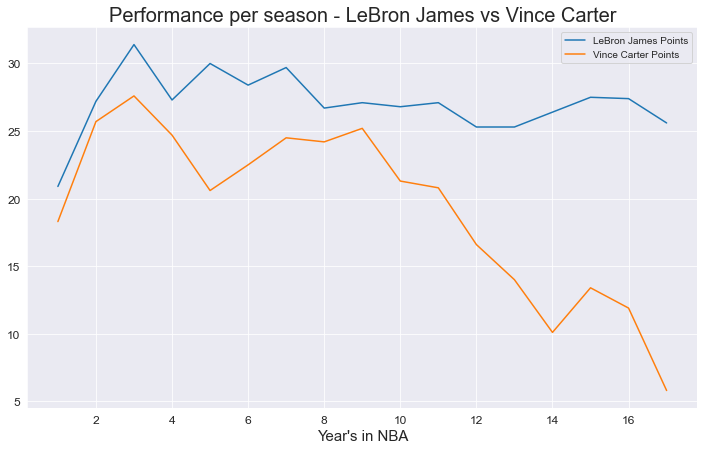

In [52]:
plt.figure(figsize = (12,7))
plt.plot(comparison['years_in_league'], comparison['lebron_pts'],  label = 'LeBron James Points')
plt.plot(comparison['years_in_league'], comparison['vince_pts'], label = 'Vince Carter Points')
plt.legend(loc = 'best')
plt.title('Performance per season - LeBron James vs Vince Carter', fontsize = 20)
plt.xlabel("Year's in NBA", fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

The data displays that Vince's performance was similar to LeBron's earlier career. Vince Carter's (coined the best dunker of all time) performance seemed to have dropped after 2006. We can see he was in his best shape between 1998-2006. Whereas, LeBron has shown no significant decline in his performance.

How has LeBron been able to maintain his performance for all these years?

One popular hypothesis has been his ability to maintain his body and adapt it through intense training and maintenence routines. ESPN and Business Insider states that LeBron reportedly spends a STAGGERING $1.5 million per year to take care of his body. (source: https://www.businessinsider.com.au/how-lebron-james-spends-money-body-care-2018-7?r=US&IR=T)

Let's explore this by comparing the Lebrons weight over time with Vince's.

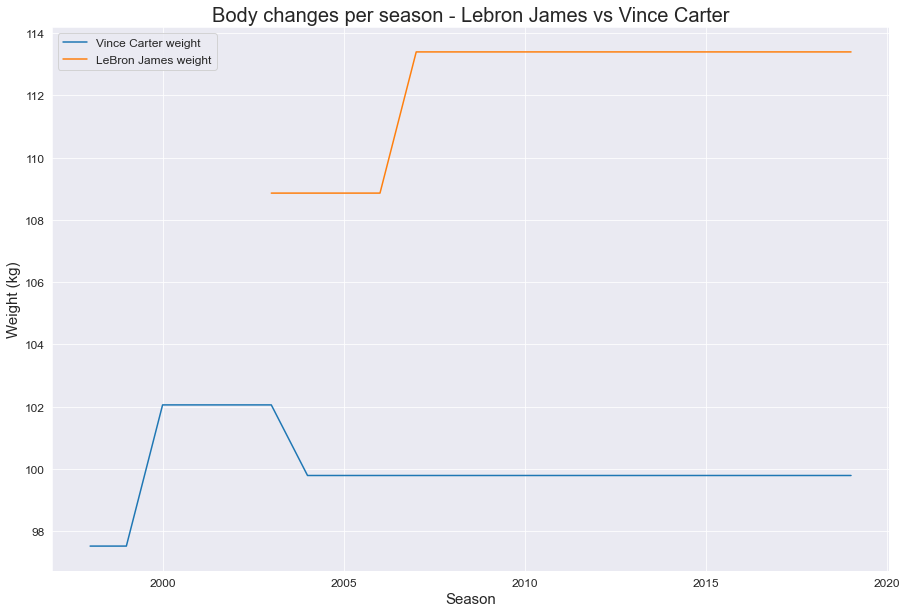

In [89]:
# Compare weights
plt.figure(figsize = (15,10)) 
plt.plot(vince_data['season'], vince_data['player_weight'], label = 'Vince Carter weight')
plt.plot(lebron_data['season'], lebron_data['player_weight'], label = 'LeBron James weight')
plt.legend(loc = 'best', fontsize = 12)
plt.title('Body changes per season - Lebron James vs Vince Carter', fontsize = 20)
plt.xlabel('Season', fontsize = 15)
plt.ylabel('Weight (kg)', fontsize = 15)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.show()

We can see that both Vince and LeBron adapted their bodies to face the competition in the NBA. Both players gained weight, most likely put on muscle to transition from playing highschool competition to facing fully-grown men. This is often the case with all NBA players.

However, we see that after Vince Carters peak performance years, his weight dropped, and maintained until the end of his career. This contrasts LeBron, who put on muscle and maintained his physique to this date. This may explain how he is able to play basketball at a high level for so many years.

# Modelling: Predicting LeBron's ppg for 2021 season

In [58]:
# Look at correlation for predictor features.
correlation = data.corr()
pts = correlation[['pts']]
# Drop row pts
pts.drop(labels = 'pts', inplace = True)
# display columns with high correlation to pts
features = pts[pts >= 0.3]
features = features[features['pts'].notna()]
features.rename(columns = {'pts': 'coefficient'}, inplace = True)
features

C:\Users\Joel\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,coefficient
gp,0.543846
reb,0.623909
ast,0.652098
usg_pct,0.633110
ts_pct,0.382417
ast_pct,0.322214


In [55]:
lebron_predict = lebron_data[['reb','ast','usg_pct','ts_pct', 'ast_pct']]
lebron_predict

,reb,ast,usg_pct,ts_pct,ast_pct
3120,5.5,5.9,0.280,0.488,0.268
3617,7.4,7.2,0.297,0.554,0.324
4075,7.0,6.6,0.336,0.568,0.315
4778,6.7,6.0,0.309,0.552,0.281
5104,7.9,7.2,0.333,0.568,0.352
5430,7.6,7.2,0.334,0.591,0.365
6127,7.3,8.6,0.333,0.604,0.398
6266,7.5,7.0,0.312,0.594,0.343
7004,7.9,6.2,0.317,0.605,0.318
7428,8.0,7.3,0.298,0.640,0.344


In [84]:
baseline_score = {}
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    plt.figure()
    plot_learning_curves(X_train, y_train, X_test, y_test, model, print_model = False, style = 'ggplot')
    plt.title(f'{model_name} Learning Curve')
    plt.show()
    print(f'Model: {model_name}' )
    print('Model score:', round(model.score(X_test, y_test),2))
    baseline_score[model_name] = round(model.score(X_test, y_test),3)
    print('----------------------------------------------------------')
    print('Baseline Scores List')
    print(baseline_score)

In [81]:
# Assign X and y variables
X = lebron_predict
y = lebron_data['pts']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=7)

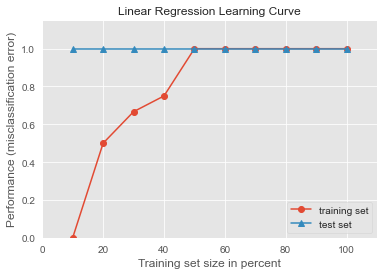

Model: Linear Regression
Model score: 0.89
----------------------------------------------------------
Baseline Scores List
{'Linear Regression': 0.885}


In [85]:
# begin modelling

lr = LinearRegression()
evaluate_model(lr, X_train, X_test, y_train, y_test, 'Linear Regression')
    

In [86]:
# Predict using stats for games played this season (37 games)
lr.predict(np.array([[7.3, 7.8, 0.317, 0.595, 0.392]]))[0]

25.427111881489303

- LeBrons predicted ppg for this season is 25.4.
- As of the 37 games played this season, his true ppg is 25.6, thats only a 0.2 point discrepancy. 